# Price-Based Control

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('simulation_results_finished.csv')
outdoor_temp_series = df['Dry-bulb temperature (°C)']
energy_price_series = df['Agile Import price (p/kWh)']

In [7]:
# Define system parameters
c_water = 4186              # Specific heat capacity of water in J/kgK
flow_rate = 300             # Flow rate in kg/30m
desired_indoor_temp = 20.0  # Desired indoor temperature in °C
base_flow_temp = 30.0       # Base flow temperature in °C

# Pricing tiers (values in p/kWh)
low_price_threshold = 10
high_price_threshold = 30

# Time step in hours
delta_t = 0.5

# Heat loss coefficient
K_water = 0.02

# Heat pump max output heat power in kW
q_HP_max = 2
# Heat pump min output heat power in kW
q_HP_min = 0.35

In [8]:
# Function to calculate required heat demand
def calculate_heat_demand(current_temp, target_temp):
    temp_difference = target_temp - current_temp
    heat_energy = (c_water * flow_rate * temp_difference)/3.6e6  
    return heat_energy/delta_t

# Function to calculate heat loss
def calculate_heat_loss(K, flow_temp, indoor_temp):
    return K * (flow_temp - indoor_temp)

In [25]:

# Initialize variables
current_flow_temp = 40  # Start with base flow temperature
heat_demand_profile = []
heat_loss_profile = []
flow_temp_series = []

# Control strategy simulation loop over time
for hour in range(len(energy_price_series)):
    outdoor_temp = outdoor_temp_series[hour]
    energy_price = energy_price_series[hour]
    
    # Determine control action based on price
    if energy_price <= low_price_threshold:
        # Low price: run heat pump at full capacity
        desired_flow_temp = 50.0
    else:
        
        if current_flow_temp <= base_flow_temp:
            desired_flow_temp = base_flow_temp
        else:
            # High price: turn off heat pump (no demand)
            desired_flow_temp = current_flow_temp  # No additional heating
    
    
    heat_loss = calculate_heat_loss(K_water, current_flow_temp, indoor_temp=20)
    # Calculate heat demand to reach target flow temperature
    if desired_flow_temp > current_flow_temp:
        heat_demand = heat_loss
        q_HP = q_HP_max
        
    else:
        heat_demand = 0  # No heat demand if target is met or heat pump is off
        q_HP = 0
    
    current_flow_temp += ((q_HP - heat_loss)*delta_t*3.6e6)/(c_water * flow_rate)

    # flow temp series
    flow_temp_series.append(current_flow_temp)
    # Append heat demand to profile
    heat_demand_profile.append(heat_demand)
    # Append heat loss to profile
    heat_loss_profile.append(heat_loss)

In [26]:
# Create a DataFrame for visualization
results_price_based = pd.DataFrame({
    "Date": df['Date'],
    "Outdoor Temp (°C)": outdoor_temp_series,
    "Energy Price (p/kWh)": energy_price_series,
    "Heat Demand (kW)": heat_demand_profile,
    "Heat Loss (kW)": heat_loss_profile,
    "Flow Temp (°C)": flow_temp_series
})

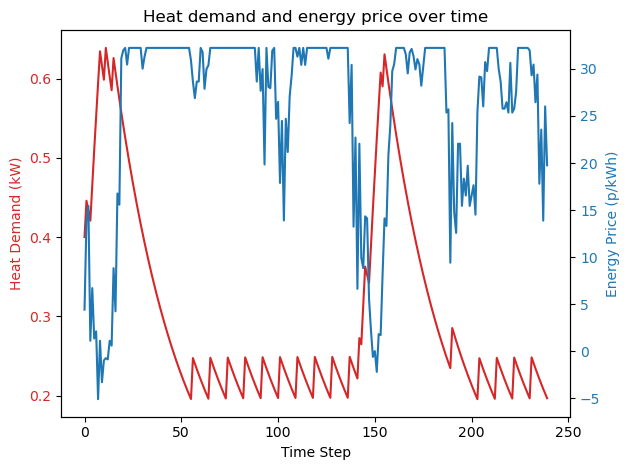

In [32]:
fig, ax1 = plt.subplots()

# Plot flow temp on primary y-axis
ax1.plot(np.arange(240), heat_loss_profile[:240], label='Heat Demand', color='tab:red')
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Heat Demand (kW)', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Create a secondary y-axis
ax2 = ax1.twinx()
ax2.plot(np.arange(240), energy_price_series[:240], label='Outdoor Temp', color='tab:blue')
ax2.set_ylabel('Energy Price (p/kWh)', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

plt.title('Heat demand and energy price over time')
fig.tight_layout()  # Adjust layout to make room for the second y-axis
plt.show()